In [1]:
import numpy as np
import h5py as h5
import matplotlib.pyplot as plt
import glob
import os
import MDAnalysis as mda
os.chdir('/home/ella/Desktop/fah_5_cut')

In [2]:
def get_dt(lst_f, angle):
    dt = []
    n_resid = []
    for i, vl in enumerate(lst_f):
        x = h5.File(vl, 'r')
        if angle in list(x.keys()):
            dt.append(np.array(x[angle]))
            n_resid.append(int(vl[30:-3]))
    dt = np.array(dt)
    return dt, np.array(n_resid)

def combine(lst_f):
    dt = []
    for i, vl in enumerate(lst_f):
        x = h5.File(vl, 'r')
        t = []
        for k, ang in enumerate(x):
            t.append(np.array(x[ang]))
        t = np.array(t)
        dt.append([max(t[:, 0]), max(t[:, 1]), 
                   max(t[:, 2]), max(t[:, 3])])
    return np.array(dt)
def finalize_dt(data, list_resid): #list_resid is an array of resid indexes starting from 1 not 0
    x = []
    ful_resid = np.arange(1, 613)
    for i, vl in enumerate(ful_resid):
        if vl not in list_resid:
            x.append([0]*4)
        elif vl in list_resid:
            x.append(data[np.where(list_resid == vl)[0][0]])
    x = np.array(x)
    return x
def write_b_factor(pdb, dt, name):
    top = mda.Universe(pdb)
    ags_A = [top.select_atoms(f'segid A and resid {i}') for i in range(1, 307)]
    ags_B = [top.select_atoms(f'segid B and resid {i}') for i in range(1, 307)]
    b_factor = []
    for i, resid in enumerate(ags_A):
        b_factor.append(np.array([dt[i]]*len(resid), dtype = float))
    for j, resid1 in enumerate(ags_B):
        b_factor.append(np.array([dt[j+306]]*len(resid1), dtype = float))
    b_factor = np.hstack(b_factor)
    top.atoms.tempfactors = b_factor
    with mda.Writer(f'{name}.pdb') as file:
        file.write(top.atoms)

In [3]:
order = np.concatenate([np.arange(1, 307), np.arange(307, 613)])
trajs = [f'Jensen_Shannon_2000/data/resid{i}.h5' for i in order]

In [4]:
f_dt = combine(trajs)
avg = finalize_dt(f_dt, order)

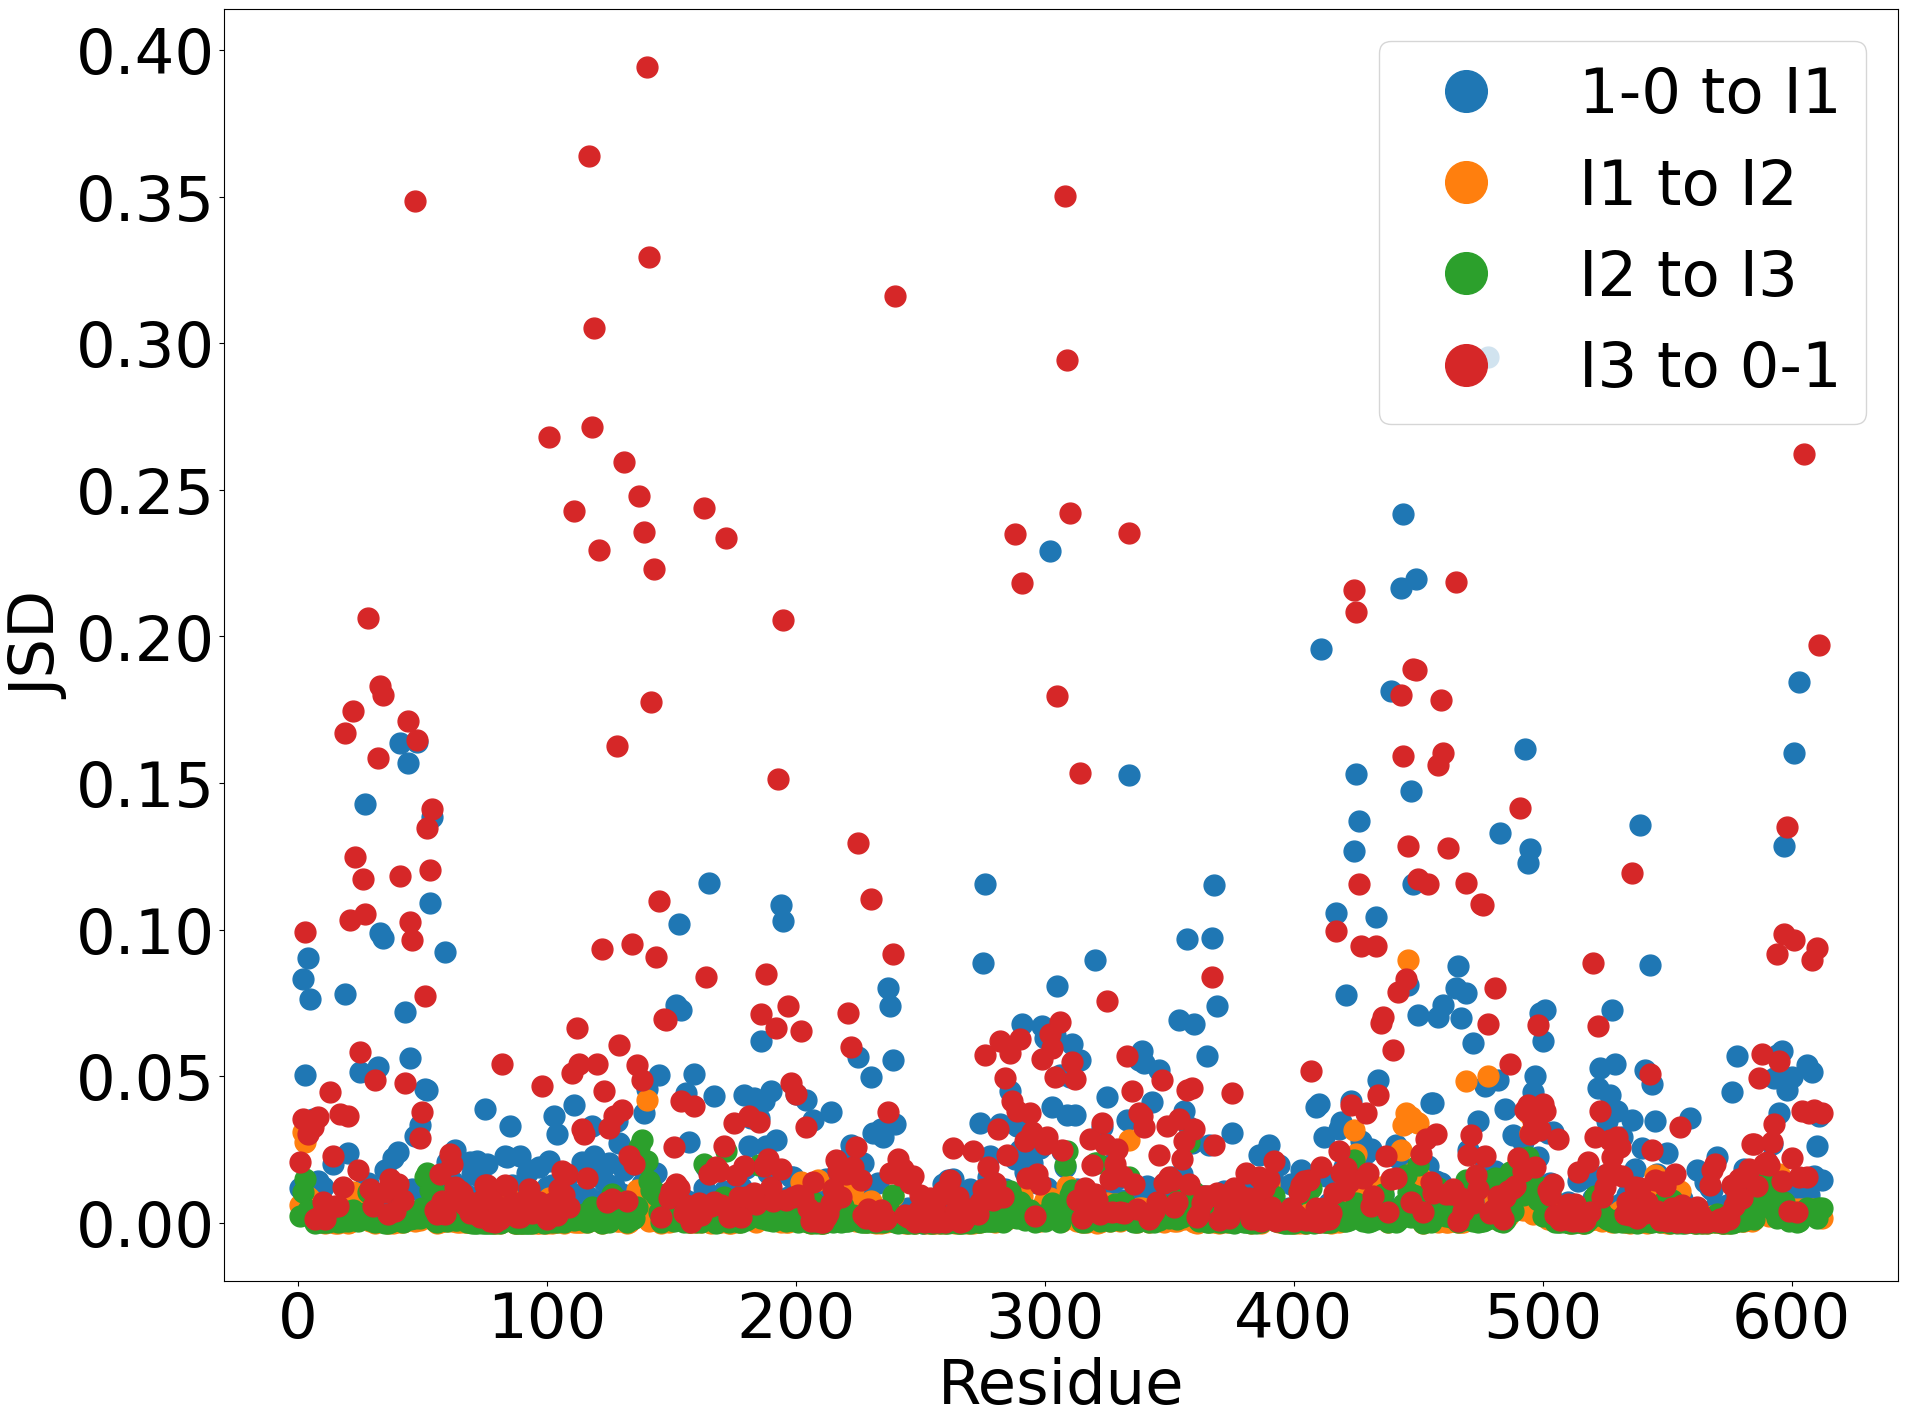

In [5]:
states = ['1-0 to I1', 'I1 to I2', 'I2 to I3', 'I3 to 0-1']
x = np.arange(1, 613)
cm = 1/2.54
ft = 45
p_size = 15
plt.figure(figsize=(8.5/cm, 6.5/cm))
plt.plot(x, f_dt[:, 0], 'o', label = states[0], markersize = p_size)
plt.plot(x, f_dt[:, 1], 'o', label = states[1], markersize = p_size)
plt.plot(x, f_dt[:, 2], 'o', label = states[2], markersize = p_size)
plt.plot(x, f_dt[:, 3], 'o', label = states[3], markersize = p_size)
plt.legend(loc = 'upper right', markerscale=2., scatterpoints=1, fontsize=ft)
plt.xlabel('Residue', fontsize = ft)
plt.tick_params(labelsize = ft)
plt.ylabel('JSD', fontsize = ft)
plt.savefig('images/JSD_states.png', bbox_inches ="tight", pad_inches = 0.3, transparent = True, facecolor ="w",
                            edgecolor ='w', orientation ='landscape')
plt.show()